# Advance Summarization Using Clustering Method

We suppose that we have a set of documents and we want to summarize the content. LLMs are great tool for this given their proficiency in understanding and synthesizing text.

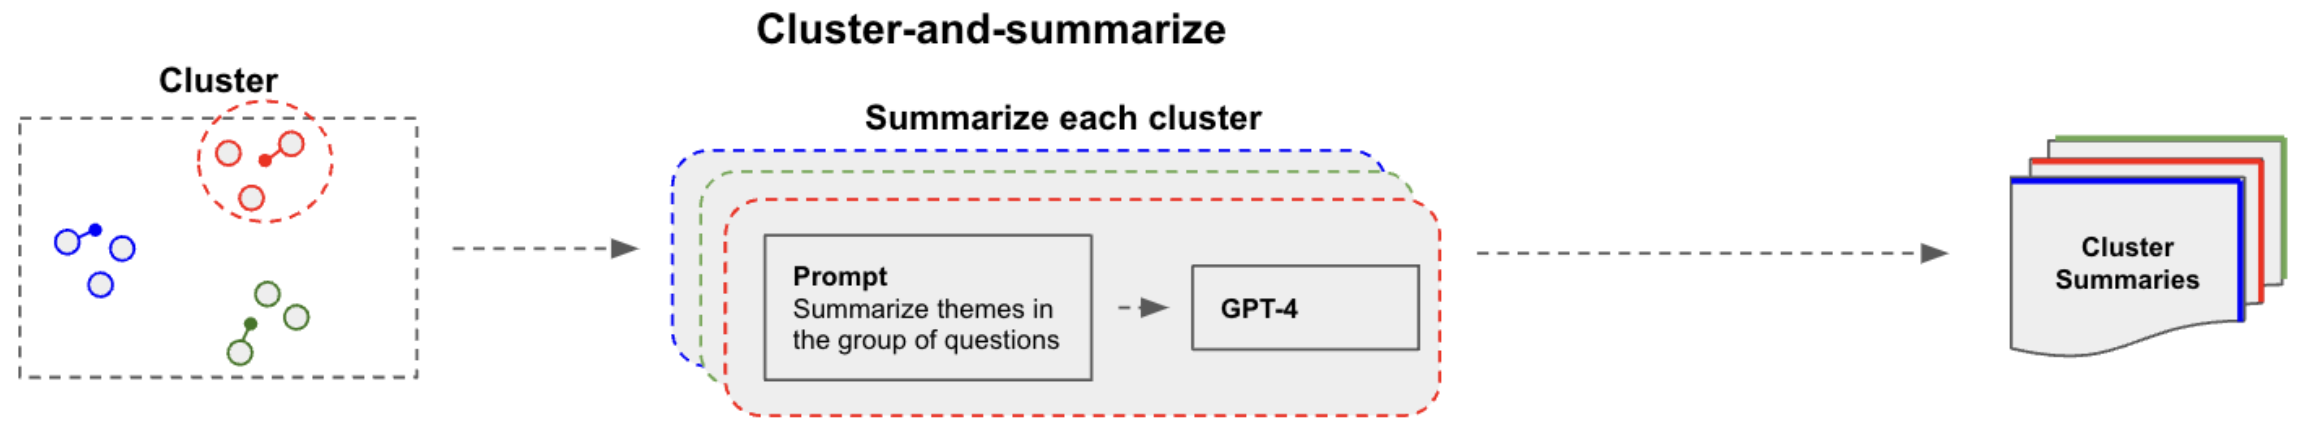

In this notebook, we'll use a simple k-means algorithm to demonstrate how clustering can be done. Clustering can help discover valuable, hidden groupings within the data. So, we'll group similiar questions together and and then summarize the themes per cluster by LLM. The dataset is available into `data` folder.

## Data Cleaning

1. Import data from csv. 
2. Gather first questions from every conversation, assuming that the first question approximates the intent of the user in the entire conversation.
3. Remove Default questions to prevent them from being clustered.

Get the first question per chat.

**Note:** We'll use mock questions generated by GPT-3 located in the data folder.

In [1]:
# imports
from os.path import exists
import ast
import numpy as np
import pandas as pd
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter

/Users/ktuna/projects/github_repos/simple_langchain_applications/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# load data
datafile_path = "data/mock_data.csv"

#load into dataframe
df = pd.read_csv(datafile_path)

# Load the CSV data into a pandas DataFrame
df = pd.read_csv(datafile_path)

# Convert string representations of lists into actual lists
df['messages'] = df['messages'].apply(ast.literal_eval)

# Extract the first message from each conversation and create a new DataFrame
first_messages = [conv[0] if conv else None for conv in df['messages']]
df_first_questions = pd.DataFrame({
    'message': first_messages,
})

# remove duplicate messages without destroying other columns
df_first_questions = df_first_questions.drop_duplicates(subset=['message'], keep='first')
df_first_questions.head()

,message
0,What is the primary objective of Retrieval Aug...
1,How does RAG differ from traditional language ...
2,What are the key components of RAG architecture?
3,Can you explain the retrieval mechanism used i...
4,What advantages does RAG offer over convention...


Alright, now that we've preprocessed the data, we can start analzying it. Here is a high level diagram of the approach we will be taking to cluster the data.

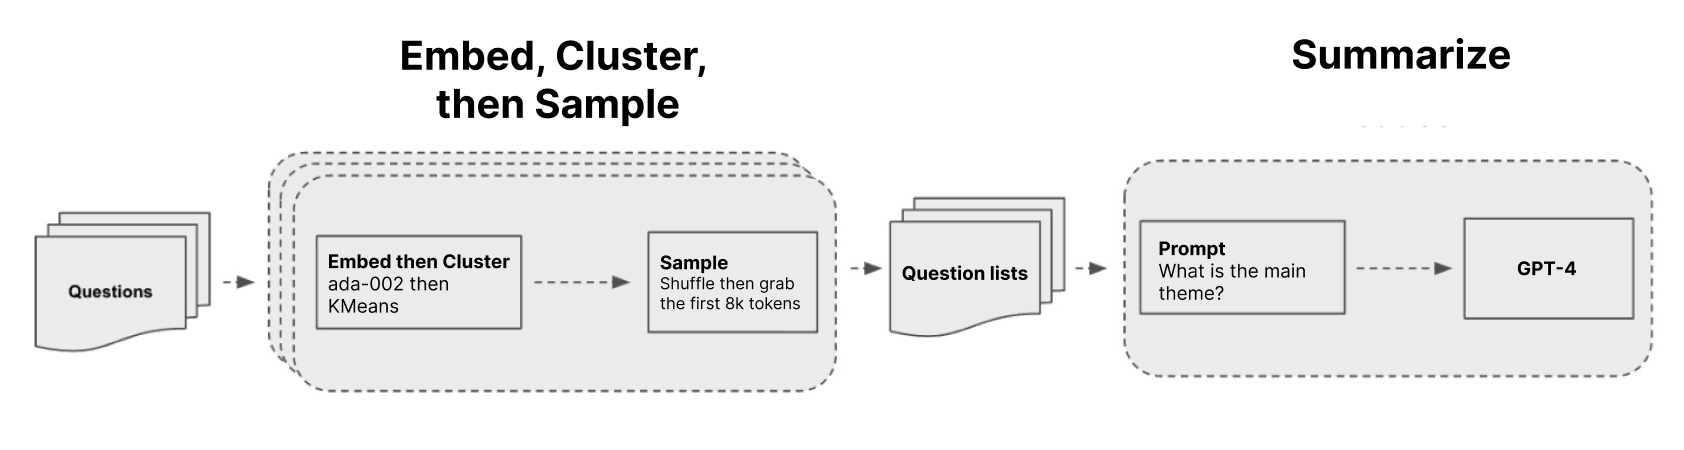

The general workflow is as follows:

1. Vectorize the data using an embedding model (in this case, we use ada)
2. Cluster the data using k-means
3. Visualize the clusters using T-SNE
4. Sample questions from the cluster
5. Summarize sampled questions with GPT-4

## Embedding

Here, we take each message and use openAI's embedding model, ada-002, to embed the message as a vector. With this numerical representation of the messages meaning, we can use clustering algorithms to group similar messages together.

In [3]:
def get_embedding(text):
    try:
        # print("used")

        embeddings = OpenAIEmbeddings()
        result = embeddings.embed_query(text)
    except: 
        print("text", text)
        result = np.zeros(512)

    return result

Embedding can be costly and time consuming, so we save the results of the embedding process to a csv file. If the csv file exists, we load the data from the csv file instead of embedding the data again.

In [4]:
#save current df_first_questions to a file so we don't have to recompute the embeddings. Make sure the embeddings are maintained
if not exists("data/df_first_questions.csv"):
    df_first_questions['embedding'] = df_first_questions["message"].apply(get_embedding)
    df_first_questions.to_csv("data/df_first_questions.csv")

/Users/ktuna/projects/github_repos/simple_langchain_applications/env/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


If you want to load from a previous embedding, set `load_from_csv` to `True`. If you want to embed the data again, set `load_from_csv` to `False`.

In [5]:
if exists("data/df_first_questions.csv"):
    df_first_questions = pd.read_csv("data/df_first_questions.csv")
    print(df_first_questions.columns)
    df_first_questions['embedding'] = df_first_questions['embedding'].apply(ast.literal_eval)

Index(['Unnamed: 0', 'message', 'embedding'], dtype='object')


In [6]:
#turn the df["embedding"] column into an np matrix
embeddingMatrix = np.array(df_first_questions["embedding"].tolist())
#print the shape of the matrix
print(embeddingMatrix.shape)
type(df_first_questions['embedding'].iloc[0])

(24, 1536)


list

## 1. Find the clusters using K-means

In [7]:
# imports
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Optional: Find the ideal number of clusters using the silhouette score

If you'd like, you can use the sillhouette score to find the ideal number of clusters. This is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The score ranges from -1 to 1, with -1 being the worst and 1 being the best. Scores around zero indicate overlapping clusters.

The ideal number of clusters is the one that maximizes the score. For this dataset, it should be around 20. However, we chose to run with 10 for consitency with the other approaches.

In [21]:
'''
silhouette_scores = []
cluster_range = range(2, 50)  # Silhouette Score is not defined for 1 cluster

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
    kmeans.fit(embeddingMatrix)
    labels = kmeans.labels_
    score = silhouette_score(embeddingMatrix, labels)
    silhouette_scores.append(score)

best_n_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print("Optimal number of clusters:", best_n_clusters)

plt.plot(cluster_range, silhouette_scores, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.show()
'''

'\nsilhouette_scores = []\ncluster_range = range(2, 50)  # Silhouette Score is not defined for 1 cluster\n\nfor n_clusters in cluster_range:\n    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)\n    kmeans.fit(embeddingMatrix)\n    labels = kmeans.labels_\n    score = silhouette_score(embeddingMatrix, labels)\n    silhouette_scores.append(score)\n\nbest_n_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]\nprint("Optimal number of clusters:", best_n_clusters)\n\nplt.plot(cluster_range, silhouette_scores, marker="o")\nplt.xlabel("Number of Clusters")\nplt.ylabel("Silhouette Score")\nplt.title("Silhouette Score")\nplt.show()\n'

### Cluster embedded messages via K-means

In [8]:

n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(embeddingMatrix)
labels = kmeans.labels_

df_first_questions["Cluster"] = labels

df_first_questions.groupby("Cluster")


### Optional: Visualize the clusters using T-SNE

We can use T-SNE to visualize the clusters. T-SNE is a dimensionality reduction technique that reduces the dimensionality of the data to 2 or 3 dimensions so that it can be visualized.

0 purple
1 green
2 red
3 blue
4 orange
5 yellow
6 pink
7 brown
8 black
9 grey


Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

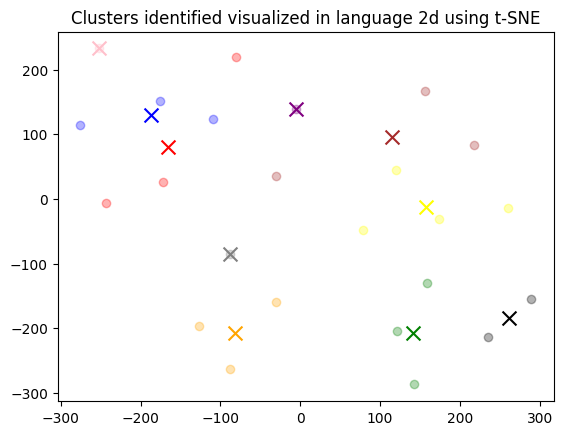

In [9]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(embeddingMatrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

colors = ["purple", "green", "red", "blue", "orange", "yellow", "pink", "brown", "black", "grey", "cyan", "magenta", "lime", "indigo", "maroon", "olive", "navy", "teal", "gold", "tan", ]

for category, color in enumerate(colors[:n_clusters]):
    print(category, color)
    xs = np.array(x)[df_first_questions.Cluster == category]
    ys = np.array(y)[df_first_questions.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
    
plt.title("Clusters identified visualized in language 2d using t-SNE")


Visualization of clusters in a 2d projection. In this run, It seems like the clusters are fairly homogonous. It would help if we optimized the cluster number based on the sillohuete score, but for consistency we will stick with Let's see a few samples from each cluster.

### Sort clusters by size and eyeball clusters

We sort the clusters by size and eyeball the clusters to see if they make sense. We should be looking to see whether each item has some similarity's to other items in the cluster

In [10]:
# sort clusters by their size, and create a new dataframe with the size and cluster number in sorted order. Maintain other columns
size_and_cluster_number = pd.DataFrame(df_first_questions.groupby("Cluster").size().sort_values(ascending=False))

# print out 10 messages from n cluster
for cluster_number, size in size_and_cluster_number.iterrows():
    print(f"{cluster_number} has {size} messages")
    print(df_first_questions[df_first_questions.Cluster == cluster_number].sample(frac=4, replace=True).message.values)
    print("\n")

5 has 0    4
Name: 5, dtype: int64 messages
['How does RAG integrate retrieved information into the generation process?'
 'How does RAG handle generating responses based on retrieved information?'
 'How does RAG handle ambiguity in retrieved information?'
 'How does RAG handle generating responses based on retrieved information?'
 'How does RAG handle generating responses based on retrieved information?'
 'How does RAG handle providing additional information from external knowledge sources?'
 'How does RAG integrate retrieved information into the generation process?'
 'How does RAG handle ambiguity in retrieved information?'
 'How does RAG integrate retrieved information into the generation process?'
 'How does RAG handle providing additional information from external knowledge sources?'
 'How does RAG handle generating responses based on retrieved information?'
 'How does RAG handle generating responses based on retrieved information?'
 'How does RAG handle generating responses based 

### Sample questions
Now, we can sample around 8000k tokens worth of questions. To do this, we shuffle the questions in each cluster, then cut the first 8000k token chunk from each cluster. This gives us a good representation of the questions in each cluster.

In [15]:
def create_doc(messages, max_tokens=8000):
    #sample around 400 messages from the cluster
    input_doc = '\n\n'.join(messages)

    text_splitter = CharacterTextSplitter.from_tiktoken_encoder(chunk_size=max_tokens,chunk_overlap=0,separator="\n\n")
    # Sanity check
    split_texts = text_splitter.split_text(input_doc)
    
    # text_splitter = CharacterTextSplitter.from_tiktoken_encoder(chunk_size=16000,chunk_overlap=0,separator="\n\n")
    return split_texts[0]

# for clusters, create docs and save in list
docs = []
for cluster_number, size in size_and_cluster_number.iterrows():
    print(f"{cluster_number} has {size} messages")
    
    messages = df_first_questions[df_first_questions.Cluster == cluster_number].message.values
    doc = create_doc(messages)
    print(doc, "\n\n")

    docs.append(doc)


5 has 0    4
Name: 5, dtype: int64 messages
How does RAG handle generating responses based on retrieved information?

How does RAG handle ambiguity in retrieved information?

How does RAG handle providing additional information from external knowledge sources?

How does RAG integrate retrieved information into the generation process? 


1 has 0    3
Name: 1, dtype: int64 messages
What techniques are used to ensure diversity and coherence in RAG-generated responses?

How does RAG ensure that generated responses are contextually relevant?

What techniques does RAG use to ensure generated responses are coherent and contextually relevant? 


2 has 0    3
Name: 2, dtype: int64 messages
What challenges does RAG face in terms of scalability and efficiency?

What are some potential limitations or drawbacks of RAG?

What are some potential future directions for research in the field of RAG? 


3 has 0    3
Name: 3, dtype: int64 messages
What are some potential applications of RAG in real-world 

## Summarize with GPT-4

Alright, now its time to take these sample questions and turn them into something interperetable. We're going to use GPT-4 to find the overall themes with each cluster, along with the most common subthemes and topics in each cluster.

In [16]:
# imports
from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate

In [17]:
map_template_string = """The following is a list of questions, commands, and keyords that have been entered into a Q+A system
{questions}

Based on this list of questions, please do 3 things: 
(1) Identify the main theme
(2) Give a list of main sub-themes
(3) Give a representitive example question in each sub-theme
(4) estimate the proportion of questions that fall into each theme

Helpful Answer:"""

MAP_PROMPT = PromptTemplate(input_variables=["questions"], template=map_template_string)


In [18]:
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(chunk_size=16000,chunk_overlap=0,separator="\n\n")

def run_map(input_doc):
    # llm = ChatOpenAI(model_name="gpt-3.5-turbo-16k", temperature=0)
    llm = ChatOpenAI(model_name="gpt-4", temperature=0)
    
    map_llm_chain = LLMChain(llm=llm, prompt=MAP_PROMPT)

    return map_llm_chain.run(questions=input_doc)

Before we run this for each cluster, lets manually evalutate the first cluster to see if it makes sense.

In [19]:
test_result = run_map(docs[0])

print(test_result)

/Users/ktuna/projects/github_repos/simple_langchain_applications/env/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(
/Users/ktuna/projects/github_repos/simple_langchain_applications/env/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(
/Users/ktuna/projects/github_repos/simple_langchain_applications/env/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was depreca

(1) The main theme of these questions is the functionality and operation of RAG (Retrieval-Augmented Generation) in information retrieval and response generation.

(2) The main sub-themes are:
   - Handling of generated responses based on retrieved information
   - Handling of ambiguity in retrieved information
   - Integration of external knowledge sources
   - Integration of retrieved information into the generation process

(3) Representative example questions for each sub-theme:
   - Handling of generated responses based on retrieved information: "How does RAG handle generating responses based on retrieved information?"
   - Handling of ambiguity in retrieved information: "How does RAG handle ambiguity in retrieved information?"
   - Integration of external knowledge sources: "How does RAG handle providing additional information from external knowledge sources?"
   - Integration of retrieved information into the generation process: "How does RAG integrate retrieved information into

Alright, now lets run it for each cluster and print the results.

In [20]:
initial_results = []

for input_doc in docs:
    result=run_map(input_doc)
    initial_results.append(result)

In [22]:
#print results
for i, result in enumerate(initial_results):
    #print size of cluster
    print(f"Cluster {i} has {size_and_cluster_number.iloc[i].values[0]} messages: \n")

    #print the summary
    print(result)

    #print separator
    print("\n===============================================================\n\n")

Cluster 0 has 4 messages: 

(1) The main theme of these questions is the functioning of RAG (Retrieval-Augmented Generation) in generating responses.

(2) The main sub-themes are:
   - Handling of ambiguity in retrieved information
   - Integration of retrieved information into the generation process
   - Provision of additional information from external knowledge sources

(3) Representative example questions for each sub-theme are:
   - Handling of ambiguity in retrieved information: "How does RAG handle ambiguity in retrieved information?"
   - Integration of retrieved information into the generation process: "How does RAG integrate retrieved information into the generation process?"
   - Provision of additional information from external knowledge sources: "How does RAG handle providing additional information from external knowledge sources?"

(4) Given that there are three questions and three sub-themes, it can be estimated that each sub-theme represents approximately 33.3% of the q